# Model 1: Failure Prediction

In [28]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import numpy as np

In [2]:
df = pd.read_csv('Data/ai4i20.csv')

In [3]:
df 

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


- Sensor features

In [4]:
num_features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

- Binary target xolumn --> failure flag  

In [10]:
target_col = 'Machine failure'

In [11]:
missing_cols = [c for c in num_features + [target_col] if c not in df.columns]
assert not missing_cols, f"Missing columns in the CSV: {missing_cols}"

X = df[num_features].copy()
y = df[target_col].astype(int).copy()

print("Shapes:", X.shape, y.shape)

Shapes: (10000, 5) (10000,)


In [9]:
print(df.columns.tolist())


['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


# STEP 2 — Train/Test split

In [12]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train/Test:", X_train.shape, X_test.shape)


Train/Test: (8000, 5) (2000, 5)


# Preprocessor for numeric scaling (used in Logistic Regression pipeline)

In [15]:

num_pre = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_features)],
    remainder="drop"
)

models = {
    "LogisticRegression": Pipeline([
        ("pre", num_pre),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "RandomForest": Pipeline([
        ("pre", "passthrough"),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ("pre", "passthrough"),
        ("clf", GradientBoostingClassifier(random_state=42))
    ])
}


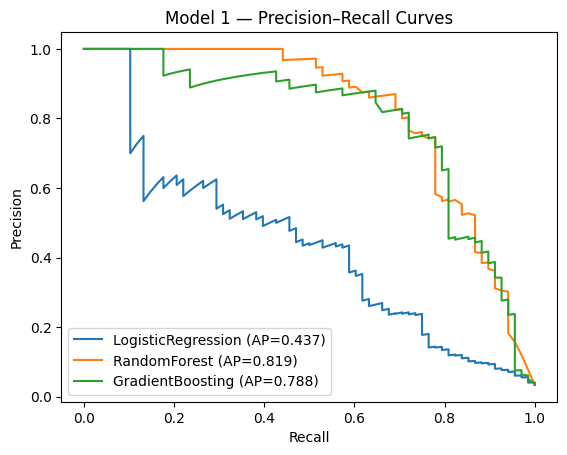


=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.970     0.998     0.984      1932
           1      0.692     0.132     0.222        68

    accuracy                          0.969      2000
   macro avg      0.831     0.565     0.603      2000
weighted avg      0.961     0.969     0.958      2000


=== RandomForest ===
              precision    recall  f1-score   support

           0      0.988     0.996     0.992      1932
           1      0.863     0.647     0.739        68

    accuracy                          0.985      2000
   macro avg      0.925     0.822     0.866      2000
weighted avg      0.983     0.985     0.983      2000


=== GradientBoosting ===
              precision    recall  f1-score   support

           0      0.987     0.997     0.992      1932
           1      0.878     0.632     0.735        68

    accuracy                          0.985      2000
   macro avg      0.932     0.815     0.864      200

In [19]:
ap_scores = {}

plt.figure()
for name, pipe in models.items():
    # Train
    pipe.fit(X_train, y_train)

    # Get positive-class scores for PR curve
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    # Precision–Recall curve + Average Precision
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    ap_scores[name] = ap

    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

# Plot formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Model 1 — Precision–Recall Curves")
plt.legend()
plt.show()

# Print classification report at the default threshold
for name, pipe in models.items():
    y_pred = pipe.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))

print("\nAverage Precision scores:", ap_scores)


#  Model 2: Failure Type Classification


In [20]:
failure_flags = ["TWF", "HDF", "PWF", "OSF", "RNF"]
assert all(c in df.columns for c in failure_flags), "Failure flag columns are missing."

# Keep only rows where exactly one failure type is active
df_multi = df[df[failure_flags].sum(axis=1) == 1].copy()

# Map the '1' position to the corresponding label
df_multi["failure_type"] = df_multi[failure_flags].idxmax(axis=1)

print(df_multi["failure_type"].value_counts())

failure_type
HDF    106
PWF     80
OSF     78
TWF     42
RNF     18
Name: count, dtype: int64


In [21]:
num_features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

missing = [c for c in num_features if c not in df_multi.columns]
assert not missing, f"Missing feature columns: {missing}"

X = df_multi[num_features].copy()
y = df_multi["failure_type"].astype(str).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (259, 5) (65, 5)
